In [1]:
import torch
import torch.nn as nn

In [2]:
class LSTMCell_v1(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        # forget gate
        self.W_if = nn.Linear(input_size, hidden_size)
        self.W_hf = nn.Linear(hidden_size, hidden_size)

        # input gate
        self.W_ii = nn.Linear(input_size, hidden_size)
        self.W_hi = nn.Linear(hidden_size, hidden_size)
        self.W_ig = nn.Linear(input_size, hidden_size)
        self.W_hg = nn.Linear(hidden_size, hidden_size)

        # output gate
        self.W_io = nn.Linear(input_size, hidden_size)
        self.W_ho = nn.Linear(hidden_size, hidden_size)

    
    def forget_gate(self, x, h):
        sum = self.W_if(x) + self.W_hf(h)
        return torch.sigmoid(sum)
    
    def input_gate(self, x, h):
        sum_i = self.W_ii(x) + self.W_hi(h)
        
        return torch.sigmoid(sum_i)
    
    def gate_gate(self, x, h):
        sum_g = self.W_ig(x) + self.W_hg(h)
        return torch.tanh(sum_g)

    def output_gate(self, x, h):
        sum = self.W_io(x) + self.W_ho(h)
        return torch.sigmoid(sum)
    
    def forward(self, x, hx):
        """
        hx[0] = h0 (previous hidden state)
        hx[1] = c0 (previous cell state)
        """
        f = self.forget_gate(x, hx[0])

        i = self.input_gate(x, hx[0])

        g = self.gate_gate(x, hx[0])

        c = f * hx[1] + i * g

        o = self.output_gate(x, hx[0])

        h = o * torch.tanh(c)

        return h, c

In [3]:
cell = LSTMCell_v1(3, 2)

input = torch.tensor([1.0, 2.0, 3.0])

h0 = torch.zeros(2)
c0 = torch.zeros(2)

output = cell(input, (h0, c0))

output

(tensor([-0.0136,  0.0510], grad_fn=<MulBackward0>),
 tensor([-0.0877,  0.0929], grad_fn=<AddBackward0>))

# LSTM Cell Efficient Linear

![Screenshot 2025-03-15 at 20.45.04.png](<attachment:Screenshot 2025-03-15 at 20.45.04.png>)
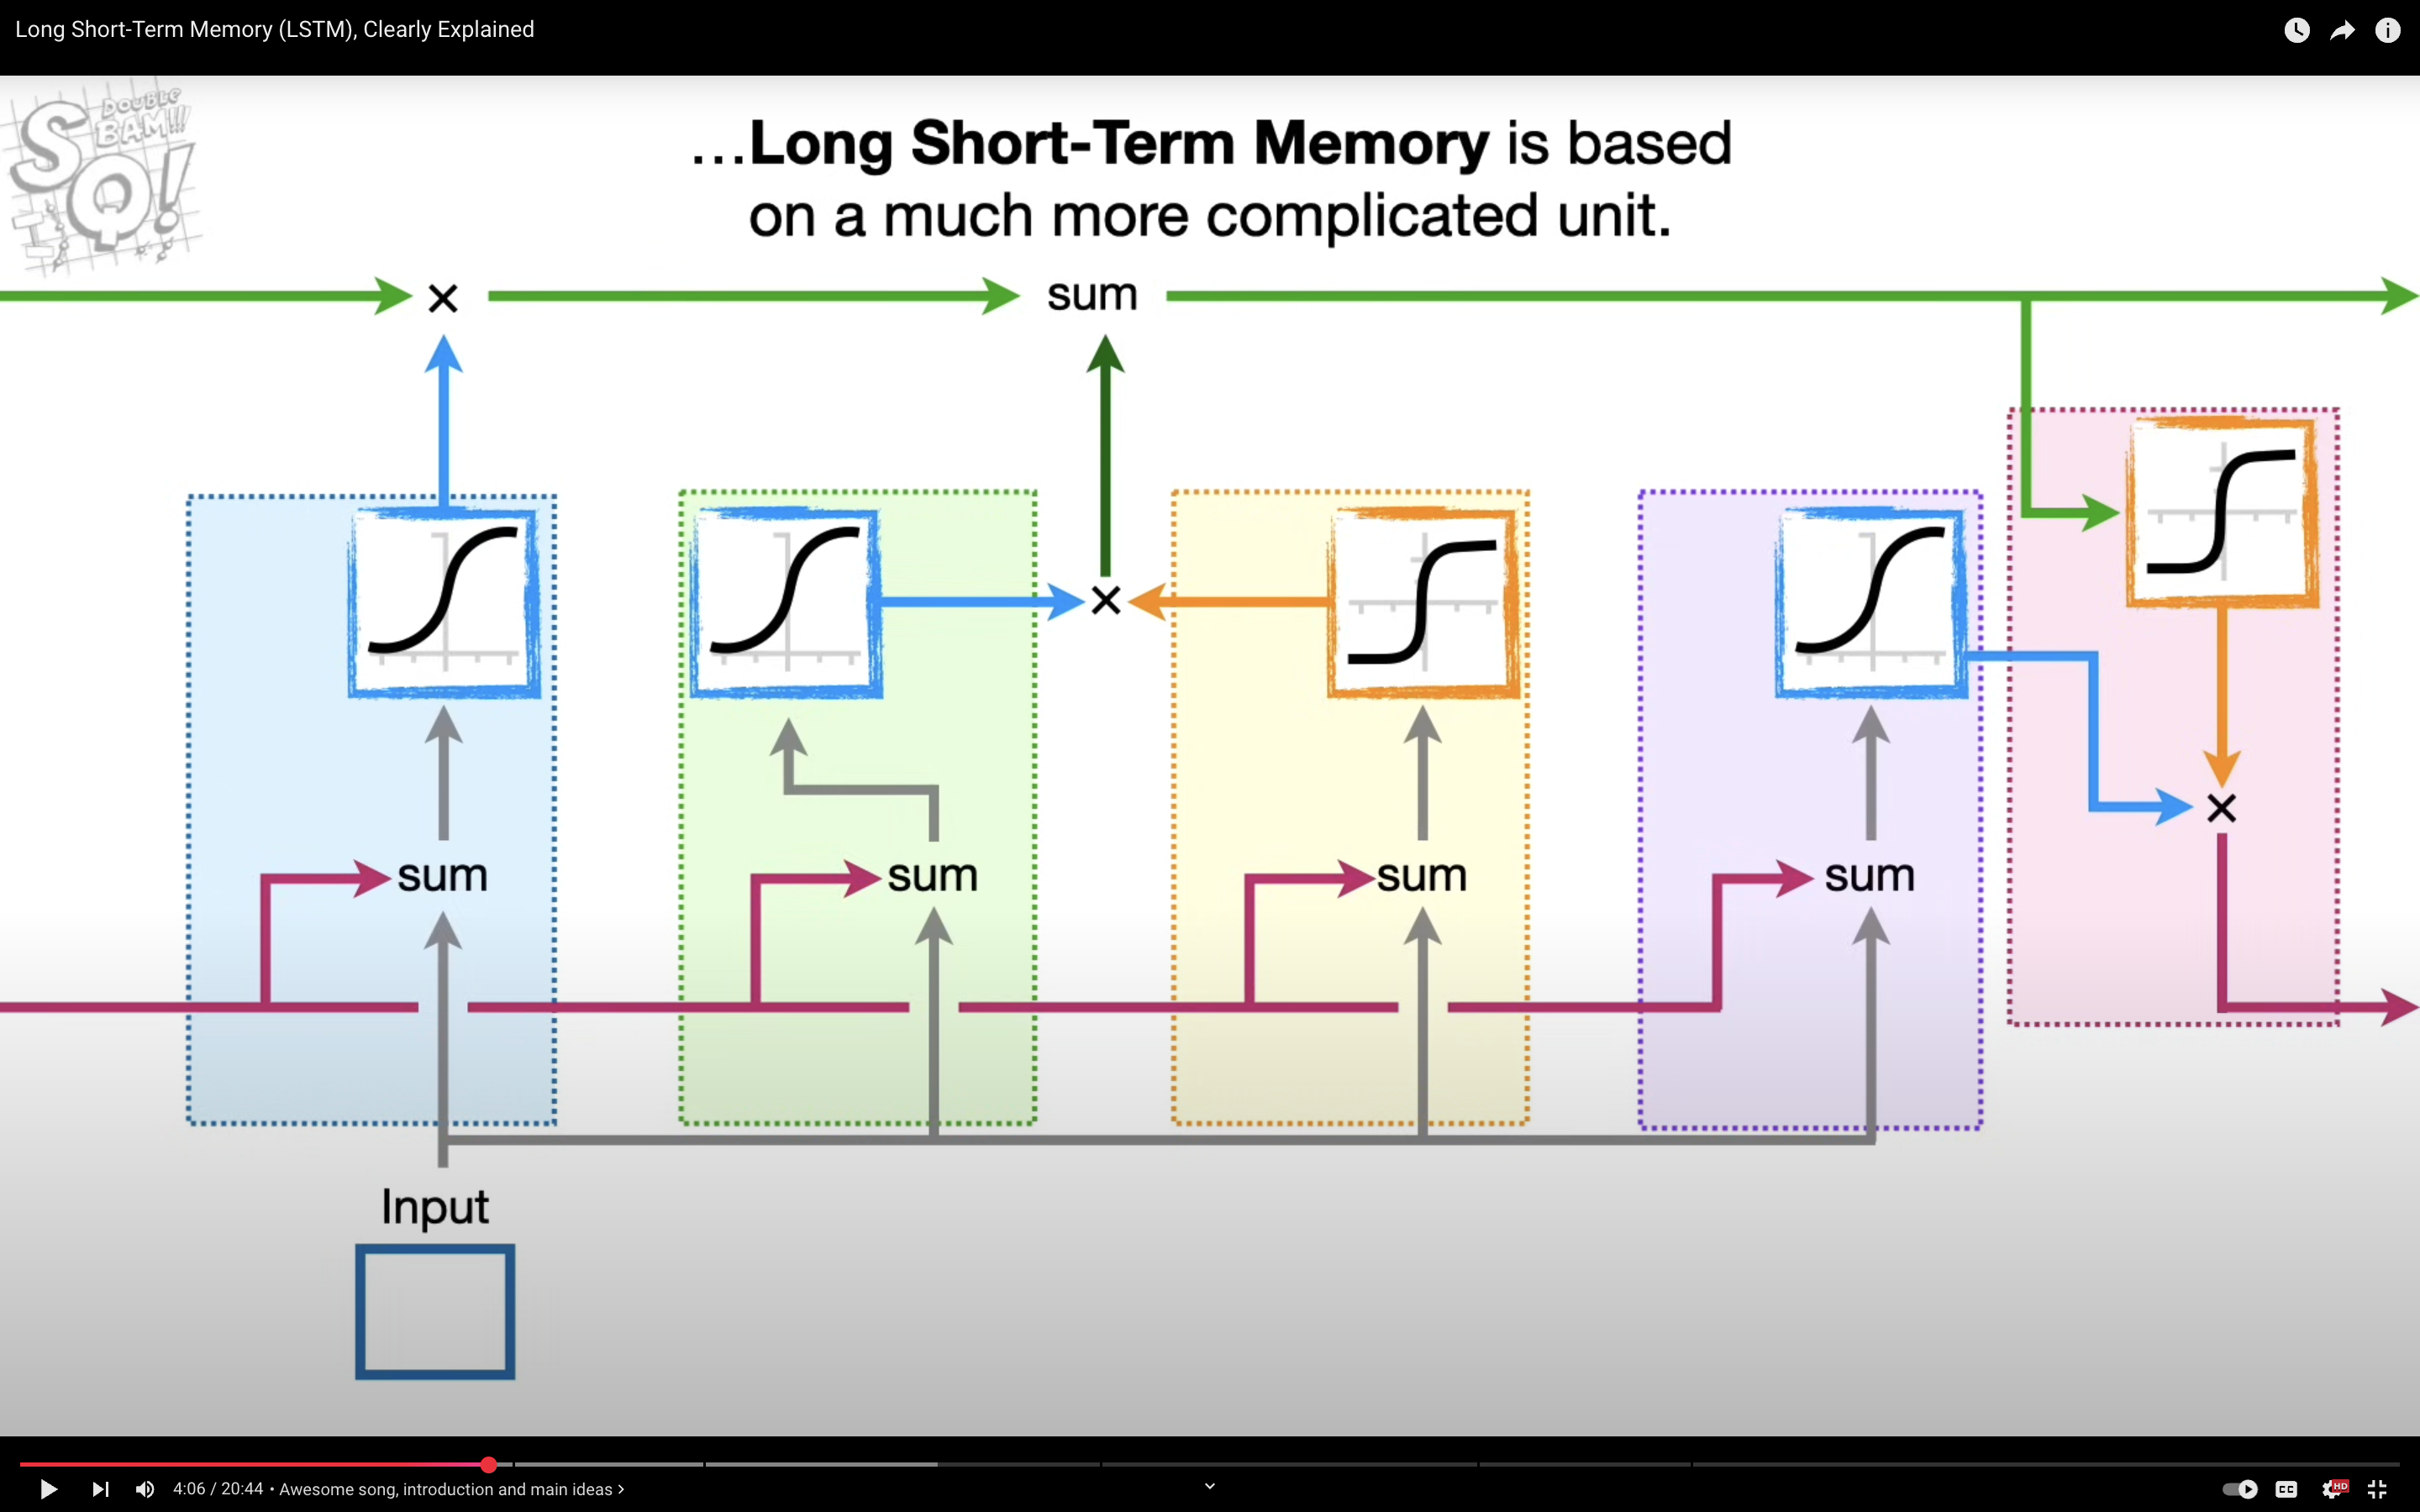

In [4]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.W_x = nn.Linear(input_size, 4 * hidden_size) # 4 is for forget, input, gate, and output gate
        self.W_h = nn.Linear(hidden_size, 4 * hidden_size)
    
    def forward(self, x, hx):
        assert x.shape[-1] == self.W_x.in_features, "Input size mismatch"
        assert hx[0].shape[-1] == self.W_x.out_features // 4, "Output size mismatch"

        gates = self.W_x(x) + self.W_h(hx[0])
        f, i, g, o = torch.chunk(gates, 4, dim=-1)
        f = torch.sigmoid(f)
        i = torch.sigmoid(i)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        c = f * hx[1] + i * g

        h = o * torch.tanh(c)

        return h, c

In [5]:
cell = LSTMCell(5, 3)

input = torch.tensor([1., 2., 3., 4., 5.,])

h0 = torch.zeros(3)
c0 = torch.zeros(3)

output = cell(input, (h0, c0))

output

(tensor([0.1761, 0.0148, 0.4325], grad_fn=<MulBackward0>),
 tensor([0.7827, 0.1725, 0.5500], grad_fn=<AddBackward0>))

In [6]:
input = torch.randn(3, 4, 5)
input

tensor([[[ 0.1195, -0.2427, -0.9611,  0.5320, -2.3102],
         [ 0.4877,  1.0431,  0.8586, -0.3078,  2.6141],
         [ 0.2589, -0.9733, -1.6025,  1.4277,  0.6385],
         [-0.7495,  0.5077, -0.1007, -0.6688,  0.1554]],

        [[ 1.0665,  0.2208,  1.8834, -1.1158, -0.2876],
         [ 1.5418, -1.6930, -1.5466, -0.6099, -0.0300],
         [ 0.0327, -0.7160,  1.0028,  0.9985,  0.7949],
         [-2.0103,  0.2070, -0.9969, -1.3104, -0.7697]],

        [[-0.2051,  0.0206, -0.3492,  0.2328,  1.5664],
         [ 0.5154,  0.4913, -0.6668, -0.8935, -0.5981],
         [ 0.7033, -0.9606,  1.4943,  0.4578, -0.7708],
         [ 0.6048, -0.2460,  1.2659,  0.9342, -0.8268]]])

In [7]:
cell = LSTMCell(5, 3)

# 3 batch, 4 input_size/sequence_length, 5 emb_size
# input = torch.tensor([[1., 2., 3., 4., 5.,], [1., 2., 3., 4., 5.,], [1., 2., 3., 4., 5.,]])
input = torch.randn(3, 4, 5)

h0 = torch.zeros(3)
c0 = torch.zeros(3)

ht, ct = cell(input[:,0], (h0, c0))

ht

tensor([[-0.1999, -0.0150, -0.1023],
        [-0.1042, -0.0923, -0.0475],
        [-0.0583,  0.0196,  0.0155]], grad_fn=<MulBackward0>)

In [8]:
ht[:, -1]

tensor([-0.1023, -0.0475,  0.0155], grad_fn=<SelectBackward0>)

# LSTM

In [94]:
class LSTM_v1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.0, bidirectional=False, device=None):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.device = device

        # create layers
        self.layers = torch.nn.ModuleList()
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        if self.bidirectional:
            self.backward_layers = torch.nn.ModuleList()
        
        for i in range(num_layers):
            if i == 0:
                self.layers.append(LSTMCell(self.input_size, self.hidden_size))
                if self.bidirectional:
                    self.backward_layers.append(LSTMCell(self.input_size, self.hidden_size))
            else:
                self.layers.append(LSTMCell(self.hidden_size, self.hidden_size))
                if self.bidirectional:
                    self.backward_layers.append(LSTMCell(self.hidden_size, self.hidden_size))
            
        self.num_layers = num_layers * self.num_directions

    def forward(self, x: torch.tensor, h0: tuple[torch.tensor, torch.tensor] = None):
        assert x.shape[-1] == self.input_size, "Input size mismatch"
        if h0 is not None:
            assert h0[0].shape[-1] == self.hidden_size, "Output size mismatch"

        seq_length = x.shape[1]
        batch_size = x.shape[0]
        if h0 is None:
            hx, cx = torch.chunk(torch.zeros(self.num_layers*2, batch_size, self.hidden_size), 2)
        else:
            hx, cx = h0

        # output = torch.tensor([]) # contains all hidden state for the last layer (batch_size, seq_length, hidden_size * D)
        h_n = torch.tensor([]) # contains all last hidden state for every layer (num_layers * D, batch_size, hidden_size)
        c_n = torch.tensor([])  # contains all last cell state for every layer (num_layers * D, batch_size, hidden_size)
        # output_backward = torch.tensor([])
        h_n_backward = torch.tensor([])
        c_n_backward = torch.tensor([])

        input_backward = None
        ht_backward = None

        
        # loop layers
        for i in range(len(self.layers)):
            next_layer_input = torch.tensor([])

            if i == 0:
                input = x
                if self.bidirectional:
                    input_backward = x.flip(dims=(1,))
                    next_layer_input_backward = torch.tensor([])
            else:
                if self.bidirectional:
                    next_layer_input_backward = torch.tensor([])
                
            ht, ct = hx[i], cx[i]
            ht_backward, ct_backward = hx[self.num_layers//2+i], cx[self.num_layers//2+i]
            for j in range(seq_length):
                ht, ct = self.layers[i](input[:,j], (ht,ct)) # take input on [all batch, current seq length]
                next_layer_input = torch.cat([next_layer_input, ht.unsqueeze(1)], dim=1)
                # hx = ht.clone().detach()

                if self.bidirectional:
                    # ht_backward, ct_backward = self.backward_layers[i](input_backward[:,j], (ht[i+1],ct[i+1]))
                    ht_backward, ct_backward = self.backward_layers[i](input_backward[:,j], (ht_backward,ct_backward))
                    next_layer_input_backward = torch.cat([next_layer_input_backward, ht_backward.unsqueeze(1)], dim=1)
                    # input_backward = ht_backward
            
            # append the h_n output of hidden state where n = seq_length on every layer
            h_n = torch.cat([h_n, ht.unsqueeze(0)])
            c_n = torch.cat([c_n, ct.unsqueeze(0)])
            if self.bidirectional:
                h_n_backward = torch.cat([h_n_backward, ht_backward.unsqueeze(0)])
                c_n_backward = torch.cat([c_n_backward, ct_backward.unsqueeze(0)])

            input = next_layer_input.clone().detach()
            if self.bidirectional:
                input_backward = next_layer_input_backward.clone().detach()

        # output = ht
        output = next_layer_input.clone().detach()
        if ht_backward is not None:
            output_backward = next_layer_input_backward.clone().detach()
            output = torch.cat([output, output_backward], dim=2)
            h_n = torch.cat([h_n, h_n_backward], dim=0)
        
        assert output.shape == (batch_size, seq_length, self.hidden_size * self.num_directions), "Output shape mismatch"
        assert h_n.shape == (len(self.layers) * self.num_directions, batch_size, self.hidden_size), "Hidden state mismatch"
        return output, h_n, c_n

In [95]:
batch_size = 2
input_size = 6
hidden_size = 4
num_layers = 2
seq_length = 3

lstm = LSTM_v1(input_size, hidden_size, num_layers=num_layers, bidirectional=True)
inputs = torch.randn(batch_size, seq_length, input_size)
# hx = torch.zeros(4)
# cx = torch.zeros(4)

# output, h_n, c_n = lstm(inputs, (hx, cx))
output, h_n, c_n = lstm(inputs)
output.shape, h_n.shape

(torch.Size([2, 3, 8]), torch.Size([4, 2, 4]))

- output shape should be (batch_size, seq_length, hidden_size * D) -> (2, 3, 4*2) which is true
- hidden state shape should be (num_layers * D, batch_size, hidden_size) -> (2*2, 2, 4) which is true

In [ ]:
class LSTM_v2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, bidirectional=False, device=None):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.device = device
        self.layers_backward = None

        self.layers_forward = nn.ModuleList([LSTMCell(self.input_size, self.hidden_size) if i == 0 else LSTMCell(self.hidden_size, self.hidden_size) for i in range(num_layers)])
        if bidirectional:
            self.layers_backward = nn.ModuleList([LSTMCell(self.input_size, self.hidden_size) if i == 0 else LSTMCell(self.hidden_size, self.hidden_size) for i in range(num_layers)])
    
    def forward(self, x, h0: tuple[torch.tensor, torch.tensor] = None):
        assert x.shape[-1] == self.input_size, f"Input's last shape did not match. Expected ({self.input_size}) but got ({x.shape[-1]}) instead"

        batch_size = x.shape[0]
        seq_length = x.shape[1]

        # initialize hx, cx, output
        if h0 is None:
            hx = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size, device=self.device)
            cx = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size, device=self.device)
        else:
            assert h0[0].shape == (self.num_layers * self.num_directions, batch_size, self.hidden_size), f"h0 shape did not match. Expected ({self.num_layers * self.num_directions, batch_size, self.hidden_size}) but got ({h0[0].shape}) instead"
            hx, cx = h0[0], h0[1]

        output = torch.zeros(batch_size, seq_length, self.hidden_size * self.num_directions, device=self.device)
        h_n = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size, device=self.device)
        c_n = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size, device=self.device)

        # iterate each layer
        for layer in range(self.num_layers):
            if layer == 0:
                input_forward = x
                layer_outputs_forward = torch.zeros(batch_size, seq_length, self.hidden_size, device=self.device)
                if self.bidirectional:
                    input_backward = torch.flip(x, dims=(1,))
                    layer_outputs_backward = torch.zeros(batch_size, seq_length, self.hidden_size, device=self.device)

            # hidden state start value for each layer
            ht_forward = hx[layer]
            ct_forward = cx[layer]
            if self.bidirectional:
                ht_backward = hx[self.num_layers * self.num_directions//2 +layer]
                ct_backward = cx[self.num_layers * self.num_directions//2 +layer]
            
            # iterate each word sequence
            for seq in range(seq_length):
                # output of each word/cell
                ht_forward, ct_forward = self.layers_forward[layer](input_forward[:,seq], (ht_forward,ct_forward)) # (batch_size, hidden_size)

                # for every cell output, insert to layer_outputs_forward
                layer_outputs_forward[:,seq] = ht_forward

                if self.bidirectional:
                    ht_backward, ct_backward = self.layers_backward[layer](input_backward[:,seq], (ht_backward, ct_backward))
                    layer_outputs_backward[:,seq] = ht_backward

            # set current layer output as next layer input
            input_forward = layer_outputs_forward.clone().detach()
            if self.bidirectional:
                input_backward = layer_outputs_backward.clone().detach()
                
            # save the last value of ht_forward and ct_forward to h_n and c_n
            h_n[layer] = ht_forward
            c_n[layer] = ct_forward
            if self.bidirectional:
                h_n[layer+1] = ht_backward
                c_n[layer+1] = ct_backward
        # output has all hidden states of all sequence on the last layer with shape (batch_size, seq_len, hidden_size * num_directions)
        # output = input_forward # input_forward contain all of the hidden states on all sequences on the last layer
        output[:, :, :self.hidden_size] = input_forward
        if self.bidirectional:
            # flip the backward pass
            input_backward_aligned = torch.flip(input_backward, dims=(1,))
            # output = torch.cat([output, input_backward], dim=-1) # concat the hidden states on backward layer on the last dimension
            output[:, :, self.hidden_size:] = input_backward_aligned
        
        assert output.shape == (batch_size, seq_length, self.hidden_size * self.num_directions), f"Output shape mismatch. Expected ({(batch_size, seq_length, self.hidden_size * self.num_directions)}) but got ({output.shape}) instead"
        assert h_n.shape == (self.num_layers * self.num_directions, batch_size, self.hidden_size), f"h_n shape mismatch. Expected ({(self.num_layers * self.num_directions, batch_size, self.hidden_size)}) but got ({h_n.shape}) instead"
        return output, h_n, c_n

In [103]:
batch_size = 2
input_size = 6
hidden_size = 4
num_layers = 2
seq_length = 3

lstm = LSTM_v2(input_size, hidden_size, num_layers=num_layers, bidirectional=True)
inputs = torch.randn(batch_size, seq_length, input_size)
# hx = torch.zeros(4)
# cx = torch.zeros(4)

# output, h_n, c_n = lstm(inputs, (hx, cx))
output, h_n, c_n = lstm(inputs)
output.shape, h_n.shape

(torch.Size([2, 3, 8]), torch.Size([4, 2, 4]))

# LSTM Efficient

In [107]:
from typing import Tuple, Optional

class LSTM(nn.Module):
    """
    # Custom LSTM implementation built from scratch using LSTMCell.
    
    This implementation supports multiple layers and bidirectional processing.
    It processes sequences by applying an LSTM cell at each time step and
    propagating the hidden states across layers.
    """
    
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 num_layers: int = 1, 
                 bidirectional: bool = False, 
                 device: Optional[torch.device] = None):
        """
        # Initialize the LSTM module with configurable parameters.
        
        Args:
            input_size: Size of input features
            hidden_size: Size of hidden state
            num_layers: Number of stacked LSTM layers
            bidirectional: Whether to use bidirectional processing
            device: Device to place tensors on (CPU/GPU)
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.device = device
        self.layers_backward = None

        # Create forward LSTM layers with appropriate input sizes
        self.layers_forward = nn.ModuleList(
            [LSTMCell(input_size, hidden_size) if i == 0 
             else LSTMCell(hidden_size, hidden_size) 
             for i in range(num_layers)]
        )
        
        # Create backward LSTM layers if bidirectional
        if bidirectional:
            self.layers_backward = nn.ModuleList(
                [LSTMCell(input_size, hidden_size) if i == 0 
                 else LSTMCell(hidden_size, hidden_size) 
                 for i in range(num_layers)]
            )
    
    def forward(self, 
                x: torch.Tensor, 
                h0: Optional[Tuple[torch.Tensor, torch.Tensor]] = None
               ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        # Forward pass of the LSTM module.
        
        Args:
            x: Input tensor of shape (batch_size, seq_length, input_size)
            h0: Optional initial hidden state tuple (h, c) of shape 
                (num_layers * num_directions, batch_size, hidden_size)
                
        Returns:
            Tuple containing:
            - output: Tensor of shape (batch_size, seq_length, hidden_size * num_directions)
            - h_n: Final hidden state of shape (num_layers * num_directions, batch_size, hidden_size)
            - c_n: Final cell state of shape (num_layers * num_directions, batch_size, hidden_size)
        
        # Note: This implementation manually handles the sequence processing that
        # PyTorch's built-in LSTM would do automatically.
        """
        # Validate input dimensions
        assert x.shape[-1] == self.input_size, f"Input's last dimension did not match. Expected ({self.input_size}) but got ({x.shape[-1]}) instead"

        batch_size = x.shape[0]
        seq_length = x.shape[1]

        # Initialize hidden and cell states
        if h0 is None:
            # Create zero tensors for initial states if not provided
            hx = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size, device=self.device)
            cx = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size, device=self.device)
        else:
            # Validate provided initial states
            assert h0[0].shape == (self.num_layers * self.num_directions, batch_size, self.hidden_size), \
                f"h0 shape did not match. Expected ({self.num_layers * self.num_directions, batch_size, self.hidden_size}) but got ({h0[0].shape}) instead"
            hx, cx = h0[0], h0[1]

        # Pre-allocate output tensors
        output = torch.zeros(batch_size, seq_length, self.hidden_size * self.num_directions, device=self.device)
        h_n = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size, device=self.device)
        c_n = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size, device=self.device)

        # Process each layer
        for layer in range(self.num_layers):
            # Initialize layer-specific variables
            if layer == 0:
                # For first layer, input is the original sequence
                input_forward = x
                layer_outputs_forward = torch.zeros(batch_size, seq_length, self.hidden_size, device=self.device)
                
                if self.bidirectional:
                    # For bidirectional, flip the sequence on time dimension
                    input_backward = torch.flip(x, dims=(1,))
                    layer_outputs_backward = torch.zeros(batch_size, seq_length, self.hidden_size, device=self.device)

            # Get initial hidden states for this layer
            ht_forward = hx[layer]
            ct_forward = cx[layer]
            
            if self.bidirectional:
                # Index calculation for bidirectional hidden states
                backward_idx = self.num_layers + layer
                ht_backward = hx[backward_idx]
                ct_backward = cx[backward_idx]
            
            # Process each time step in the sequence
            for seq in range(seq_length):
                # Forward pass for this time step
                ht_forward, ct_forward = self.layers_forward[layer](input_forward[:,seq], (ht_forward, ct_forward))
                layer_outputs_forward[:,seq] = ht_forward

                if self.bidirectional:
                    # Backward pass for this time step
                    ht_backward, ct_backward = self.layers_backward[layer](input_backward[:,seq], (ht_backward, ct_backward))
                    layer_outputs_backward[:,seq] = ht_backward

            # Prepare inputs for next layer
            # .clone() creates a copy
            input_forward = layer_outputs_forward.clone()
            
            if self.bidirectional:
                input_backward = layer_outputs_backward.clone()
                
            # Store final hidden states for this layer
            h_n[layer] = ht_forward
            c_n[layer] = ct_forward
            
            if self.bidirectional:
                h_n[backward_idx] = ht_backward
                c_n[backward_idx] = ct_backward
                
        # Combine outputs from forward and backward passes
        output[:, :, :self.hidden_size] = input_forward
        
        if self.bidirectional:
            # Flip backward outputs to align with forward sequence
            input_backward_aligned = torch.flip(input_backward, dims=(1,))
            output[:, :, self.hidden_size:] = input_backward_aligned
        
        # Validate output shapes
        assert output.shape == (batch_size, seq_length, self.hidden_size * self.num_directions), \
            f"Output shape mismatch. Expected ({batch_size, seq_length, self.hidden_size * self.num_directions}) but got ({output.shape}) instead"
        assert h_n.shape == (self.num_layers * self.num_directions, batch_size, self.hidden_size), \
            f"h_n shape mismatch. Expected ({self.num_layers * self.num_directions, batch_size, self.hidden_size}) but got ({h_n.shape}) instead"
            
        return output, h_n, c_n

In [109]:
batch_size = 2
input_size = 6
hidden_size = 4
num_layers = 2
seq_length = 3

lstm = LSTM(input_size, hidden_size, num_layers=num_layers, bidirectional=True)
inputs = torch.randn(batch_size, seq_length, input_size)

output, h_n, c_n = lstm(inputs)
output.shape, h_n.shape

(torch.Size([2, 3, 8]), torch.Size([4, 2, 4]))